In [1]:
import torch
from torch.utils.data import DataLoader
from torch import optim, nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np

* Data Loading

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST(root='data', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST(root='data', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

* Neural Network

In [3]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
    
model = Classifier()
model.cuda()

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

* Training the model

In [5]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 10
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    ###############
    # Train Model #
    ###############
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            ##############
            # Test Model #
            ##############
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/10..  Training Loss: 0.337..  Test Loss: 0.195..  Test Accuracy: 0.940
Epoch: 2/10..  Training Loss: 0.166..  Test Loss: 0.146..  Test Accuracy: 0.953
Epoch: 3/10..  Training Loss: 0.136..  Test Loss: 0.170..  Test Accuracy: 0.949
Epoch: 4/10..  Training Loss: 0.114..  Test Loss: 0.140..  Test Accuracy: 0.960
Epoch: 5/10..  Training Loss: 0.104..  Test Loss: 0.127..  Test Accuracy: 0.963
Epoch: 6/10..  Training Loss: 0.100..  Test Loss: 0.115..  Test Accuracy: 0.966
Epoch: 7/10..  Training Loss: 0.090..  Test Loss: 0.108..  Test Accuracy: 0.970
Epoch: 8/10..  Training Loss: 0.082..  Test Loss: 0.116..  Test Accuracy: 0.967
Epoch: 9/10..  Training Loss: 0.078..  Test Loss: 0.108..  Test Accuracy: 0.971
Epoch: 10/10..  Training Loss: 0.073..  Test Loss: 0.120..  Test Accuracy: 0.968


* Visualizing the metric Loss

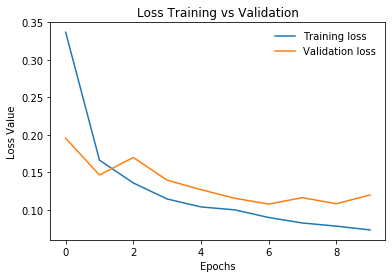

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss Training vs Validation')
plt.ylabel('Loss Value')
plt.xlabel('Epochs')
plt.legend(frameon=False)